# 4.2b - Compare all pairs of classes. How easy is to distinguish between them?

In [1]:
import os
import sys
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2b-pairs'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [4]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

# Create models

In [5]:
cats = rawset.categories
tsets, vsets = rawset.rnd_split_fraction_by_category(0.5)
tsets = tsets.by_category()
vsets = vsets.by_category()

In [6]:
if os.path.exists(result_dir + "/2classes.tsv"):
    os.remove(result_dir + "/2classes.tsv")
r = report.Reporter2(result_dir + '/2classes.tsv')
for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        print(cats[i], cats[j])
        mycats = [cats[i], cats[j]]
        myset = rawset.filter(lambda x: rawset.category_from(x) in mycats)
        myset.rebuild_categories()
        tset, vset = myset.rnd_split_fraction_by_category(0.5)

        model = CLD(2, 256)
        result = Trainer(
            model,
            xs_encoder='one_hot',
            batch_size=100,
            steps_per_epoch=28,
            validation_steps=28,
            patience=10,
        ).train(tset, vset)
        h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
        model.save(h5_path)
        print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
        r.line(cat1=cats[i],
               cat2=cats[j],
               elapsed=result.elapsed,
               **report.report_epochs(**result._asdict()),
               **report.report_metrics(**result._asdict()),
              )
r.close()

csv dbase3
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
397.0329489707947 0.9967857
csv doc
575.3763399124146 0.9917857
csv dwf
526.0626356601715 0.99964285
csv eps
327.98058438301086 0.97571427
csv f
382.29702377319336 0.9721429
csv gif
432.44748425483704 0.9992857
csv gz
280.1456437110901 0.99892855
csv hlp
560.9518013000488 0.9778572
csv html
614.6166956424713 0.9785714
csv java
336.6137034893036 0.9742857
csv jpg
621.5266211032867 0.99785715
csv kml
341.82033228874207 0.98142856
csv kmz
313.34554648399353 0.99964285
csv log
317.9798221588135 0.9735714
csv pdf
493.1502456665039 0.99964285
csv png
417.2852849960327 0.99535716
csv pps
492.42299938201904 0.9967857
csv ppt
549.4774069786072 0.99607146
csv pptx
506.80892753601074 0.9982143
csv ps
603.1343364715576 0.99035716
csv rtf
398.67329955101013 0.98642856
csv sql
396

538.0291941165924 0.91964287
html kmz
494.50492906570435 0.99785715
html log
1031.665114402771 0.9282143
html pdf
807.7607941627502 0.9885714
html png
482.008047580719 0.995
html pps
557.7294795513153 0.9932143
html ppt
784.160893201828 0.9942857
html pptx
1021.1013386249542 0.99857146
html ps
767.249653339386 0.9775
html rtf
1176.0936133861542 0.98464286
html sql
871.7701489925385 0.93642855
html swf
573.7917687892914 0.9992857
html txt
801.0413432121277 0.9210714
html wp
876.9736850261688 0.9603571
html xls
674.9918978214264 0.98
html xml
982.1032242774963 0.8503571
java jpg
572.1185631752014 0.9982143
java kml
756.4923379421234 0.97571427
java kmz
534.7552704811096 0.99857146
java log
647.0245592594147 0.9685714
java pdf
936.1920464038849 0.99
java png
496.0357401371002 0.9982143
java pps
1069.1334872245789 0.99857146
java ppt
717.468398809433 0.9917857
java pptx
727.8918449878693 0.99964285
java ps
723.7484121322632 0.9885714
java rtf
703.9844186306 0.9860714
java sql
627.271686792

# Load results

In [7]:
data = pd.read_csv(result_dir + '/2classes.tsv', sep='\t')
data

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,csv,dbase3,397.032949,16,0.996786,0.996786
1,csv,doc,575.376340,23,0.991786,0.991786
2,csv,dwf,526.062636,21,0.999643,0.999643
3,csv,eps,327.980584,13,0.975714,0.975714
4,csv,f,382.297024,15,0.972143,0.972143
...,...,...,...,...,...,...
373,txt,xls,996.888335,31,0.983214,0.983214
374,txt,xml,1090.040561,38,0.955714,0.955714
375,wp,xls,1226.306003,47,0.941786,0.941786
376,wp,xml,634.880889,18,0.966071,0.966071


In [8]:
data = data.sort_values(['val_categorical_accuracy'])
data[data['val_categorical_accuracy'] < 0.7]

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
323,pps,ppt,588.003708,12,0.517857,0.517857
176,gz,png,752.804796,23,0.593214,0.593214
90,dwf,png,851.853070,26,0.602143,0.602143
81,dwf,gz,661.326502,24,0.602857,0.602857
318,png,swf,1141.320112,31,0.603571,0.603571
324,pps,pptx,648.752734,14,0.613929,0.613929
97,dwf,swf,743.158201,21,0.618571,0.618571
91,dwf,pps,639.537662,19,0.624286,0.624286
312,png,pps,921.881599,24,0.624286,0.624286
314,png,pptx,816.892612,20,0.630357,0.630357


In [9]:
data2 = data.apply(
    lambda x: pd.Series(
        [
            rawset.cat_to_ix[x.cat1],
            rawset.cat_to_ix[x.cat2], 
            x.val_categorical_accuracy
        ], index=['cat1', 'cat2', 'val_acc'])
    , axis=1)
data2

,cat1,cat2,val_acc
323,17.0,18.0,0.517857
176,7.0,16.0,0.593214
90,3.0,16.0,0.602143
81,3.0,7.0,0.602857
318,16.0,23.0,0.603571
...,...,...,...
258,12.0,13.0,1.000000
322,16.0,27.0,1.000000
152,6.0,12.0,1.000000
38,1.0,13.0,1.000000


In [10]:
cat_acc = {}
for i, d in data.iterrows():
    cat1 = d['cat1']
    cat2 = d['cat2']
    cat_acc[cat1] = cat_acc.get(cat1, list())
    cat_acc[cat2] = cat_acc.get(cat2, list())
    cat_acc[cat1].append(d['val_categorical_accuracy'])
    cat_acc[cat2].append(d['val_categorical_accuracy'])    

No handles with labels found to put in legend.


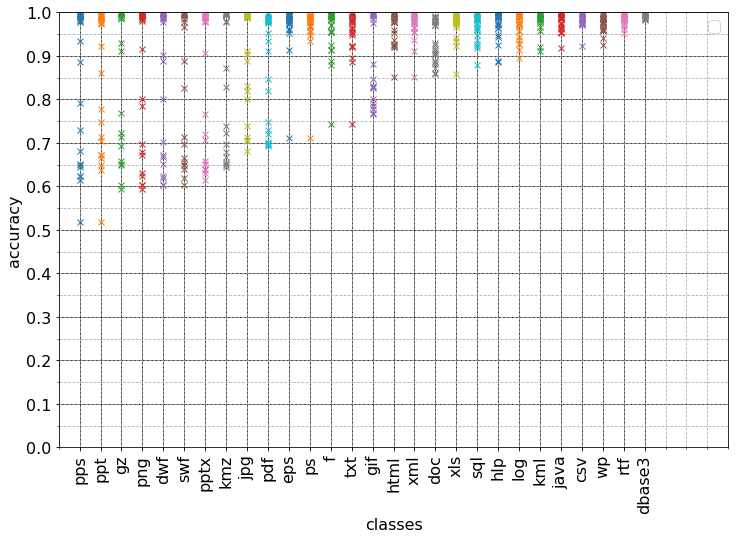

In [11]:
from matplotlib.ticker import MultipleLocator
loc='upper right'
fig = plt.figure(figsize=(12,8))
for k, v in cat_acc.items():
    plt.plot(*zip(*[(k, x) for x in v]), 'x')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('classes', fontsize=16)
plt.xlim((-1, 31))
plt.ylim((-0, 1))
ax1 = plt.gca()
# ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(linestyle='-', color='k', which='major')
plt.grid(linestyle='--', which='minor')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.legend(loc=loc, prop={'size': 16})
plt.xticks(rotation=90)
#     plt.savefig('acc.png')
plt.show()    

In [12]:
data.min()

cat1                             csv
cat2                          dbase3
elapsed                      280.146
Epochs                            11
val_binary_accuracy         0.517857
val_categorical_accuracy    0.517857
dtype: object

In [13]:
with open(result_dir + '/nclasses.tsv', 'w') as f:
    f.write('n\tcats\tval_categorical_accuracy\n')
    for i, x in data.iterrows():
        s = '2\t{}\t{}\n'.format(x.cat1+','+x.cat2,x.val_categorical_accuracy)
        f.write(s)

# Add pairs of classes to graph 4.2a

In [14]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right', alpha_on=None):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g-', 'r*', '.mD']):
        plt.plot(x[x==alpha_on], y[x==alpha_on], mark, alpha=0.1, label='')
        plt.plot(x[x!=alpha_on], y[x!=alpha_on], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')

In [15]:
data42a = pd.read_csv('results/4.2a-nclasses/nclasses.tsv', sep='\t')
data42b = pd.read_csv('results/4.2b-pairs/nclasses.tsv', sep='\t')
mdata = pd.concat([data42a, data42b])

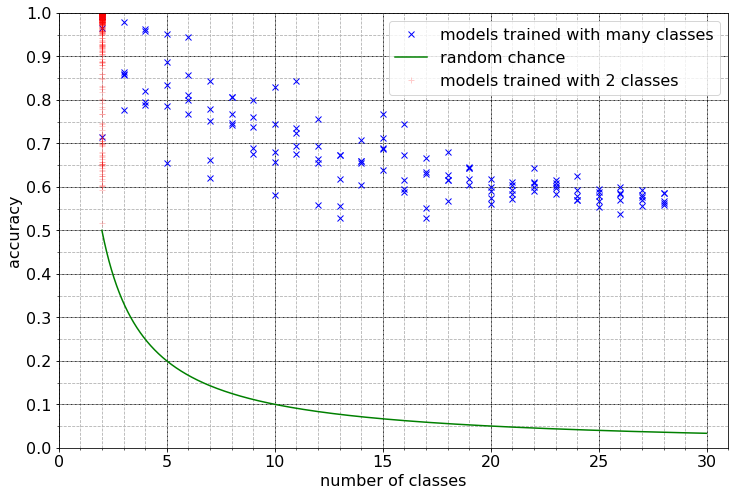

In [16]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([data42a['n'], x], [data42a['val_categorical_accuracy'], y], ['models trained with many classes', 'random chance'])
plt.plot(data42b['n'], data42b['val_categorical_accuracy'], 'r+', alpha=0.2, label='models trained with 2 classes')
plt.legend(loc='upper right', prop={'size': 16})

# PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)

In [19]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.500000,0.996786,0.991786,0.999643,0.975714,0.972143,0.999286,0.998929,0.977857,0.978571,...,0.996071,0.998214,0.990357,0.986429,0.984286,0.998571,0.921786,0.986786,0.991429,0.976786
1,0.996786,0.500000,0.987857,0.995357,0.998929,0.995714,0.998214,0.998929,0.991429,0.985714,...,0.992143,0.997143,0.995000,0.997500,0.983571,1.000000,0.997500,0.998214,0.987143,0.997500
2,0.991786,0.987857,0.500000,0.902500,0.980000,0.972143,0.880357,0.928929,0.971429,0.977857,...,0.860357,0.906071,0.970714,0.987143,0.981786,0.889286,0.980714,0.925000,0.858571,0.977143
3,0.999643,0.995357,0.902500,0.500000,0.996786,0.994286,0.800000,0.602857,0.999286,0.998929,...,0.671071,0.652143,0.984286,0.996071,0.988929,0.618571,0.999286,0.986786,0.978214,1.000000
4,0.975714,0.998929,0.980000,0.996786,0.500000,0.914643,0.995357,0.989286,0.990714,0.984643,...,0.972857,0.991429,0.710714,0.961071,0.958929,0.995000,0.975357,0.986786,0.983214,0.980000
5,0.972143,0.995714,0.972143,0.994286,0.914643,0.500000,0.998571,1.000000,0.887857,0.925357,...,0.991429,0.990714,0.956071,0.985357,0.879643,0.999286,0.744286,0.957500,0.982500,0.954643
6,0.999286,0.998214,0.880357,0.800000,0.995357,0.998571,0.500000,0.768571,0.998571,1.000000,...,0.778929,0.766429,0.994286,0.997143,0.993929,0.826071,0.999643,0.983929,0.974643,0.996786
7,0.998929,0.998929,0.928929,0.602857,0.989286,1.000000,0.768571,0.500000,0.999643,0.998571,...,0.712500,0.657857,0.985000,0.989643,1.000000,0.648929,1.000000,0.993571,0.994643,0.999286
8,0.977857,0.991429,0.971429,0.999286,0.990714,0.887857,0.998571,0.999643,0.500000,0.925714,...,0.989643,0.988571,0.992857,0.991786,0.948929,0.998929,0.885714,0.971071,0.974286,0.964643
9,0.978571,0.985714,0.977857,0.998929,0.984643,0.925357,1.000000,0.998571,0.925714,0.500000,...,0.994286,0.998571,0.977500,0.984643,0.936429,0.999286,0.921071,0.960357,0.980000,0.850357


In [20]:
data6 = pca.fit_transform(data5)

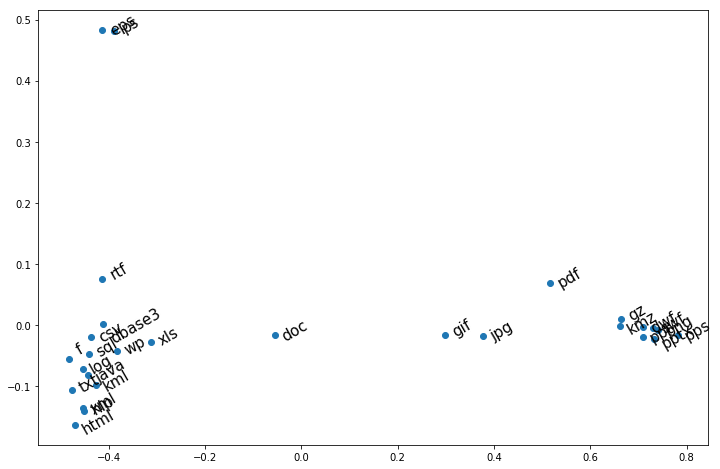

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data6[:,0], data6[:,1], 'o')

for i in range(28):
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.01, data6[i,1]+0.01),fontsize=15)
    t.set_rotation(30)

In [22]:
data6[:,0]>0.4

array([False, False, False,  True, False, False, False,  True, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True, False, False, False,
       False])

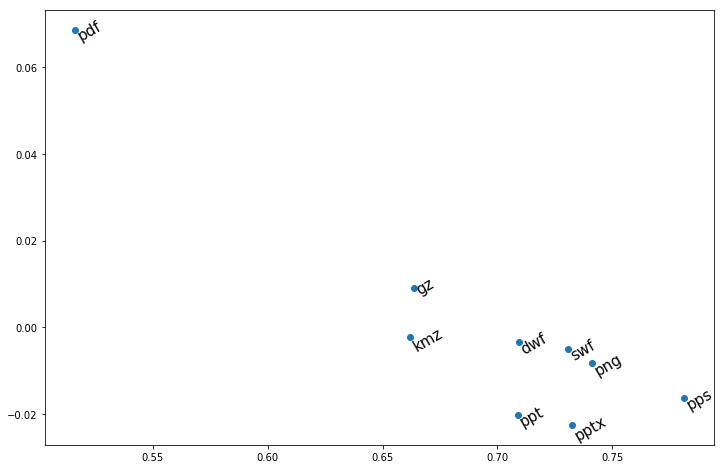

In [23]:
data7 = data6[data6[:,0]>0.4]
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(len(data6)):
    if data6[i,0] < 0.4:
        continue
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.0, data6[i,1]+0.0),fontsize=15)
    t.set_rotation(30)

# Multi-dimensional scaling

In [24]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.500000,0.996786,0.991786,0.999643,0.975714,0.972143,0.999286,0.998929,0.977857,0.978571,...,0.996071,0.998214,0.990357,0.986429,0.984286,0.998571,0.921786,0.986786,0.991429,0.976786
1,0.996786,0.500000,0.987857,0.995357,0.998929,0.995714,0.998214,0.998929,0.991429,0.985714,...,0.992143,0.997143,0.995000,0.997500,0.983571,1.000000,0.997500,0.998214,0.987143,0.997500
2,0.991786,0.987857,0.500000,0.902500,0.980000,0.972143,0.880357,0.928929,0.971429,0.977857,...,0.860357,0.906071,0.970714,0.987143,0.981786,0.889286,0.980714,0.925000,0.858571,0.977143
3,0.999643,0.995357,0.902500,0.500000,0.996786,0.994286,0.800000,0.602857,0.999286,0.998929,...,0.671071,0.652143,0.984286,0.996071,0.988929,0.618571,0.999286,0.986786,0.978214,1.000000
4,0.975714,0.998929,0.980000,0.996786,0.500000,0.914643,0.995357,0.989286,0.990714,0.984643,...,0.972857,0.991429,0.710714,0.961071,0.958929,0.995000,0.975357,0.986786,0.983214,0.980000
5,0.972143,0.995714,0.972143,0.994286,0.914643,0.500000,0.998571,1.000000,0.887857,0.925357,...,0.991429,0.990714,0.956071,0.985357,0.879643,0.999286,0.744286,0.957500,0.982500,0.954643
6,0.999286,0.998214,0.880357,0.800000,0.995357,0.998571,0.500000,0.768571,0.998571,1.000000,...,0.778929,0.766429,0.994286,0.997143,0.993929,0.826071,0.999643,0.983929,0.974643,0.996786
7,0.998929,0.998929,0.928929,0.602857,0.989286,1.000000,0.768571,0.500000,0.999643,0.998571,...,0.712500,0.657857,0.985000,0.989643,1.000000,0.648929,1.000000,0.993571,0.994643,0.999286
8,0.977857,0.991429,0.971429,0.999286,0.990714,0.887857,0.998571,0.999643,0.500000,0.925714,...,0.989643,0.988571,0.992857,0.991786,0.948929,0.998929,0.885714,0.971071,0.974286,0.964643
9,0.978571,0.985714,0.977857,0.998929,0.984643,0.925357,1.000000,0.998571,0.925714,0.500000,...,0.994286,0.998571,0.977500,0.984643,0.936429,0.999286,0.921071,0.960357,0.980000,0.850357


In [25]:
from sklearn.manifold import MDS

In [26]:
mds = MDS(n_components=2,max_iter=3000, eps=1e-9,
          n_jobs=1)

In [27]:
data7 = mds.fit_transform(data5)

/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


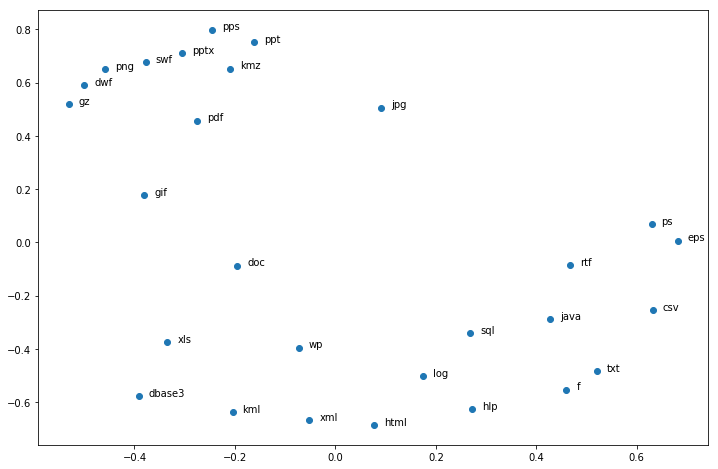

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(28):
    ax.annotate(rawset.ix_to_cat[i], (data7[i,0]+0.02, data7[i,1]))